In [1]:
# ! pip install optuna

In [2]:

import numpy
import time
import random
import numpy as np
import pandas as pd
import random

from sklearn.base import BaseEstimator
import numpy as np
import optuna
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from prophet import Prophet

In [3]:
class ExtremeValues:

    def __init__(self):
        self._wscale = None
        self._wshape = None
        self._r2 = None

    @property
    def rsquared(self) -> float:
        """The coefficient of determination for fitted parameter"""
        return self._r2

    @property
    def wscale(self) -> float:
        "Scale parameter of Weibull"
        return self._wscale

    @property
    def wshape(self) -> float:
        "Shape parameter of Weibull"
        return self._wshape

    @wscale.setter
    def wscale(self, wsc: float):
        "Set the Scale parameter of Weibull"
        self._wscale = wsc

    @wshape.setter
    def wshape(self, wsh: float):
        "Set the Shape parameter of Weibull"
        self._wshape = wsh

    def reset(self):
        "Reset Weibull Parameter"
        self._wscale = None
        self._wshape = None
        self._r2 = None

    def weibull(self, x: float) -> float:
        """The Weibull distribuction function

        Args:
            x (float): input value

        Returns:
            float: Weibull value for input x.
        """
        if x < 0:
            return 0

        tmp = (self.wshape / self.wscale)
        tmp *= ((x / self.wscale) ** (self.wshape - 1))
        tmp *= numpy.exp(-(x / self.wscale) ** self.wshape)
        return tmp

    def wblcfd(self, x: float) -> float:
        """The Weibull cumulative distribuction function

        Args:
            x (float): input value

        Returns:
            float: CFD of Weibull value for input x.
        """
        return 1.0 - numpy.exp(-(x/self.wscale) ** self.wshape)

    def fit_weibull(self, failures: numpy.ndarray) -> None:
        """The Fit Weibull from array of failures
        Considering the Weibull CFD being:
        F(x) = 1 - exp(-(x/scale) ** shape)

        Is easy to obtain
        y = shape * xl + a

        where:
        y = ln(-ln(1-F(x)))
        xl = ln(x)
        a = - shape * ln(scale)

        From the Least Square Fitting for straight line:

        shape = sum(y*(x-xm)) / (sum(x*(x-xm))

        a = ym-xm * shape

        where xm is the mean of x and ym is the mean of y.
        Args:
            x (ndarray): failures array value
        """
        x = numpy.log(numpy.sort(failures))
        y = (numpy.arange(1, x.size + 1) - 0.5) / x.size
        y[:] = numpy.log(-numpy.log(1-y))
        xm = numpy.mean(x)
        xt = x - xm
        b1 = numpy.sum(y * xt)
        b2 = numpy.sum(x * xt)
        beta = b1 / b2

        a = numpy.mean(y) - xm * beta

        alpha = numpy.exp(-a / beta)

        self.wscale = alpha
        self.wshape = beta

        # Calculating R Squared for
        # y = shape * x - shape * ln(scale)

        def yp(x): return self.wshape * x - \
            self.wshape * numpy.log(self.wscale)
        ym = numpy.mean(y)
        ssres = numpy.sum((y - yp(x)) ** 2.0)
        sstot = numpy.sum((y-ym)**2.0)
        self._r2 = 1.0 - ssres / sstot

In [4]:
class AMSystem:
    def __init__(self, window=270, gamma=1.45, nxtrem=11, moutliers=1, delta=0.99, sma=2):
        self.window = window
        self.gamma = gamma
        self.nxtrem = nxtrem
        self.moutliers = moutliers
        self.delta = delta
        self.sma = sma
        self.buffer = []
        self.sma_buffer = []
        self.n = 0
        self.zq = 0

    def update(self, value):
        self.n += 1
        self.buffer.append(value)
        if len(self.buffer) > self.window:
            self.buffer.pop(0)

        self.sma_buffer.append(value)
        if len(self.sma_buffer) > self.sma:
            self.sma_buffer.pop(0)
        smoothed = np.mean(self.sma_buffer)

        if len(self.buffer) < self.window:
            return {"outlier": 0, "regime_change": 0}

        sorted_vals = sorted(self.buffer, reverse=True)
        threshold_index = min(self.nxtrem - 1, len(sorted_vals) - 1)
        threshold = sorted_vals[threshold_index]
        outlier = int(smoothed > threshold * self.gamma)

        self.zq = self.delta * self.zq + (1 - self.delta) * outlier
        regime_change = int(self.zq > self.moutliers)
        if regime_change:
            self.zq = 0  # reset

        return {"outlier": outlier, "regime_change": regime_change}

In [5]:


class AMSystemDetector(BaseEstimator):
    def __init__(self, window=100, gamma=1.5,  nxtrem=4, moutliers=5, delta=0.99, sma=5):
        self.window = window
        self.gamma = gamma
        self.nxtrem = nxtrem
        self.moutliers = moutliers
        self.delta = delta
        self.sma = sma

    def fit(self, X, y=None):
        self.model_pos = AMSystem(window=self.window, gamma=self.gamma,
                                  nxtrem=self.nxtrem, moutliers=self.moutliers,
                                  delta=self.delta, sma=self.sma)

        self.model_neg = AMSystem(window=self.window, gamma=self.gamma,
                                  nxtrem=self.nxtrem, moutliers=self.moutliers,
                                  delta=self.delta, sma=self.sma)
        return self

    def predict(self, X):
        preds = []
        for xi in X:
            out_pos = self.model_pos.update(xi)
            out_neg = self.model_neg.update(-xi)

            is_pos_outlier = out_pos and out_pos["outlier"]
            is_neg_outlier = out_neg and out_neg["outlier"]

            preds.append(1 if is_pos_outlier or is_neg_outlier else 0)
        return np.array(preds)

    def tune(self, X, y, n_trials=50, timeout=None, verbose=True):
        def objective(trial):
          params = {
              "window": trial.suggest_int("window", 10, 300),
              "gamma": trial.suggest_float("gamma", 0.5, 3.5),
              "nxtrem": trial.suggest_int("nxtrem", 4, 30),
              "moutliers": trial.suggest_int("moutliers", 1, 20),
              "delta": trial.suggest_float("delta", 0.90, 0.999),
              "sma": trial.suggest_int("sma", 1, 20),
          }

          model_pos = AMSystem(**params)
          model_neg = AMSystem(**params)

          y_pred = []
          for xi in X:
              out_pos = model_pos.update(xi)
              out_neg = model_neg.update(-xi)
              out = (out_pos and out_pos["outlier"]) or (out_neg and out_neg["outlier"])
              y_pred.append(1 if out else 0)
          return f1_score(y, np.array(y_pred).astype(int))
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, timeout=timeout)

        if verbose:
            print("Melhores hiperparâmetros encontrados:")
            for k, v in study.best_params.items():
                print(f"{k}: {v}")
            print(f"Melhor F1-score: {study.best_value:.4f}")

        for k, v in study.best_params.items():
            setattr(self, k, v)

        self.fit(X)  # Reinstancia com os melhores parâmetros
        return self


In [6]:
def sintetic_data(npoints=300, normal_mean=1, normal_std=1.5, anl_index=[70, 200], an_val=20):
    numpy.random.seed(0)
    random.seed(time.time())

    # amplitude = 5
    # frequency = 0.02
    # phase = numpy.pi / 2
    # xtime = numpy.linspace(0, 10, npoints)
    # sinusoidal_signal = amplitude * numpy.sin(2 * numpy.pi * frequency * xtime + phase)

    ndata = numpy.random.normal(normal_mean, normal_std, npoints)

    anomaly = numpy.zeros(npoints)

    anomaly_noise = numpy.random.normal(0, normal_std, npoints)

    x = ndata + anomaly_noise

    gen_ano = [x[i] + (random.random() + 0.6) * an_val * normal_std for i in anl_index]

    anl_index = [anl_index[i] for i in range(len(anl_index)) if x[anl_index[i]] != gen_ano[i]]

    anomaly[anl_index] =  1

    x[anl_index] = gen_ano


    return {"x": x, "anomaly": anomaly}



In [7]:
data = sintetic_data(npoints=5000, anl_index=[250, 340, 1010, 3400])
X = data["x"]
y = data["anomaly"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

detector = AMSystemDetector()
detector.tune(X_train, y_train)
y_pred = detector.predict(X_test)

[I 2025-07-31 21:44:10,472] A new study created in memory with name: no-name-798620bd-b054-499a-b8e0-40e142408592
[I 2025-07-31 21:44:11,528] Trial 0 finished with value: 0.0 and parameters: {'window': 203, 'gamma': 1.716879045118683, 'nxtrem': 11, 'moutliers': 19, 'delta': 0.9916204290887497, 'sma': 9}. Best is trial 0 with value: 0.0.
[I 2025-07-31 21:44:11,788] Trial 1 finished with value: 0.0 and parameters: {'window': 56, 'gamma': 2.28143668160272, 'nxtrem': 19, 'moutliers': 12, 'delta': 0.9057815080810601, 'sma': 13}. Best is trial 0 with value: 0.0.
[I 2025-07-31 21:44:12,548] Trial 2 finished with value: 0.5 and parameters: {'window': 205, 'gamma': 1.6080842000027529, 'nxtrem': 25, 'moutliers': 13, 'delta': 0.9958114071745592, 'sma': 9}. Best is trial 2 with value: 0.5.
[I 2025-07-31 21:44:13,153] Trial 3 finished with value: 0.4 and parameters: {'window': 179, 'gamma': 1.1392273899480259, 'nxtrem': 5, 'moutliers': 18, 'delta': 0.9377651942627586, 'sma': 4}. Best is trial 2 wit

Melhores hiperparâmetros encontrados:
window: 249
gamma: 3.3155553716400394
nxtrem: 15
moutliers: 6
delta: 0.9269496392508587
sma: 1
Melhor F1-score: 0.8000


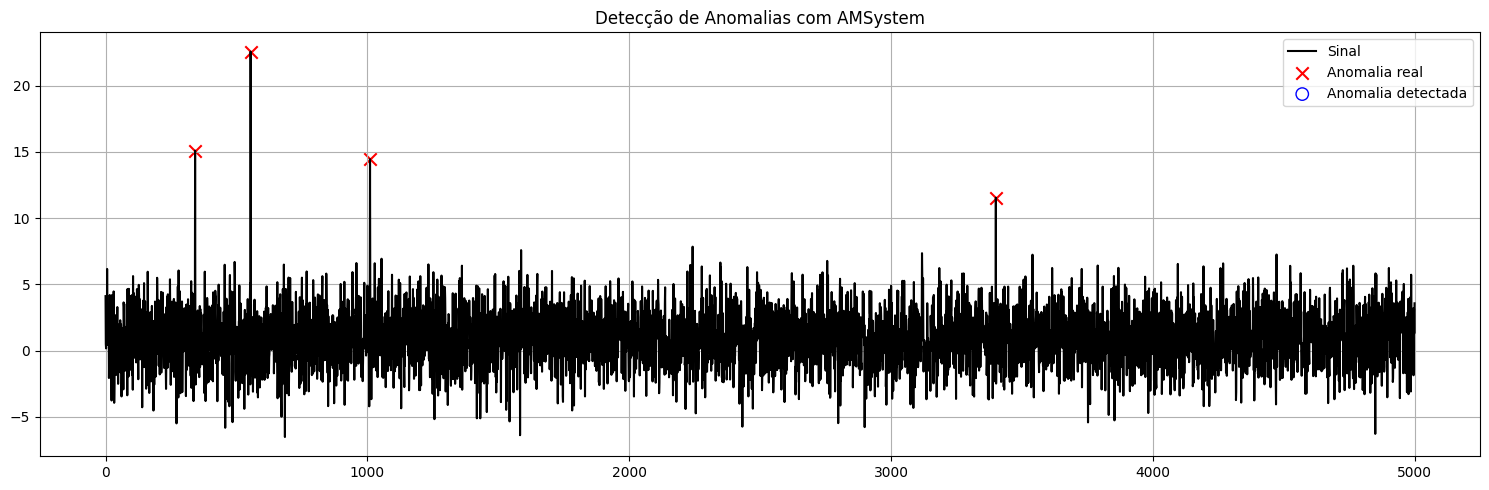

F1-score: 0.000


In [10]:
# --- Execução do modelo e coleta de resultados ---
def run_and_plot():
    data_dict = sintetic_data(npoints=5000, anl_index=[342, 554, 1010, 3400], an_val=10)
    x = data_dict["x"]
    y_true = data_dict["anomaly"]

    model = AMSystem(window=100, gamma=1.5,  nxtrem=4, moutliers=5, delta=0.99, sma=5)
    y_pred = []

    for xi in x:
        result = model.update(xi)
        # print(result)
        if result:
            y_pred.append(result["outlier"])
        else:
            y_pred.append(0)

    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(x, color="black", label="Sinal")

    true_idx = np.where(y_true == 1)[0]
    pred_idx = np.where(y_pred == 1)[0]

    plt.scatter(true_idx, x[true_idx], color="red", marker="x", s=80, label="Anomalia real")
    plt.scatter(pred_idx, x[pred_idx], color="blue", marker="o", facecolors="none", s=80, label="Anomalia detectada")

    plt.title("Detecção de Anomalias com AMSystem")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Métrica simples
    f1 = f1_score(y_true, y_pred)
    print(f"F1-score: {f1:.3f}")

run_and_plot()

In [15]:
import optuna
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Reutiliza seu sintetic_data() e AMSystem (certifique-se que já estão definidos)

def objective(trial):
    # Sugestão dos hiperparâmetros
    window = trial.suggest_int("window", 10, 300)
    gamma = trial.suggest_float("gamma", 1.0, 3.0)
    nxtrem = trial.suggest_int("nxtrem", 1, 20)
    moutliers = trial.suggest_int("moutliers", 1, 20)
    delta = trial.suggest_float("delta", 0.90, 0.999)
    sma = trial.suggest_int("sma", 1, 20)

    # Gera os dados sintéticos
    data_dict = sintetic_data(npoints=5000, anl_index=[342, 554, 1010, 3400], an_val=10)
    x = data_dict["x"]
    y_true = np.array(data_dict["anomaly"]).astype(int)

    # Roda o modelo
    model = AMSystem(
        window=window,
        gamma=gamma,
        nxtrem=nxtrem,
        moutliers=moutliers,
        delta=delta,
        sma=sma,
    )

    y_pred = []
    for xi in x:
        result = model.update(xi)
        y_pred.append(result["outlier"] if result else 0)

    y_pred = np.array(y_pred).astype(int)

    # Calcula F1-score
    score = f1_score(y_true, y_pred)

    return score  # Otimiza o F1-score

# Cria e executa o estudo
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Resultados
print("Melhores parâmetros encontrados:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

print(f"Melhor F1-score: {study.best_value:.4f}")


[I 2025-07-31 21:47:51,709] A new study created in memory with name: no-name-73312f7b-36a2-482f-9666-32f585fdeb40
[I 2025-07-31 21:47:52,001] Trial 0 finished with value: 0.0 and parameters: {'window': 215, 'gamma': 1.8689781588406866, 'nxtrem': 20, 'moutliers': 9, 'delta': 0.9136137405118471, 'sma': 11}. Best is trial 0 with value: 0.0.
[I 2025-07-31 21:47:52,266] Trial 1 finished with value: 0.0 and parameters: {'window': 201, 'gamma': 1.5704273006720233, 'nxtrem': 5, 'moutliers': 8, 'delta': 0.9165222659973137, 'sma': 9}. Best is trial 0 with value: 0.0.
[I 2025-07-31 21:47:52,356] Trial 2 finished with value: 1.0 and parameters: {'window': 53, 'gamma': 2.6011642607187357, 'nxtrem': 6, 'moutliers': 20, 'delta': 0.9857673642308066, 'sma': 1}. Best is trial 2 with value: 1.0.
[I 2025-07-31 21:47:52,638] Trial 3 finished with value: 0.0 and parameters: {'window': 216, 'gamma': 2.664985468504521, 'nxtrem': 3, 'moutliers': 4, 'delta': 0.9805104174453624, 'sma': 15}. Best is trial 2 with 

Melhores parâmetros encontrados:
window: 53
gamma: 2.6011642607187357
nxtrem: 6
moutliers: 20
delta: 0.9857673642308066
sma: 1
Melhor F1-score: 1.0000


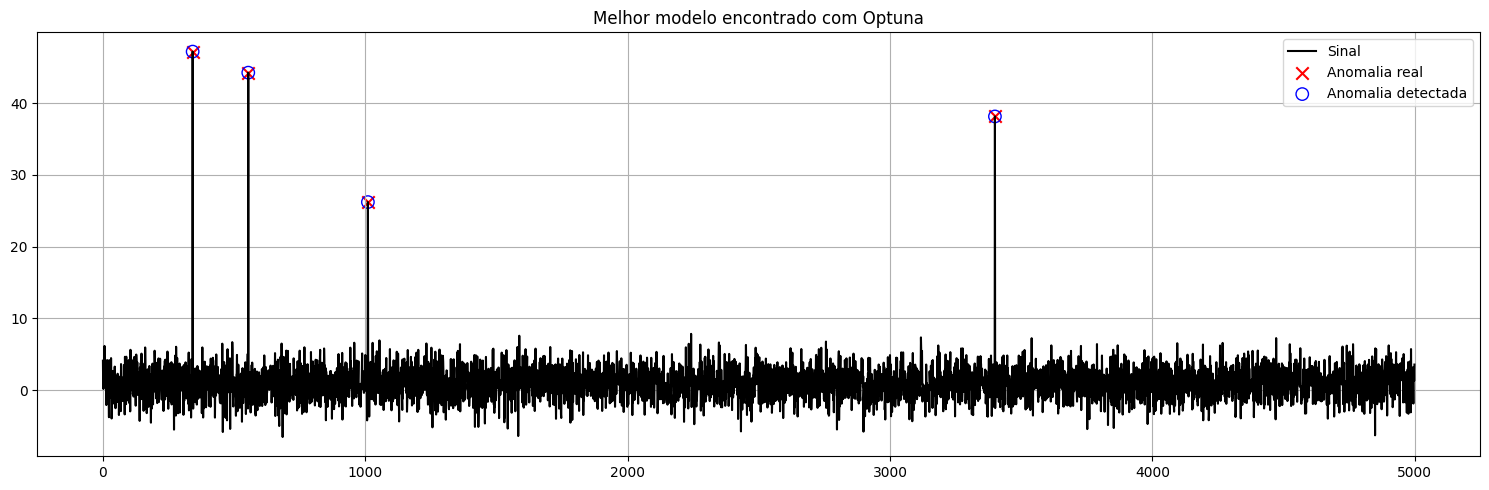

In [16]:
best_params = study.best_params
model = AMSystem(**best_params)

x = sintetic_data(npoints=5000, anl_index=[342, 554, 1010, 3400])["x"]
y_true = np.array(sintetic_data(npoints=5000, anl_index=[342, 554, 1010, 3400])["anomaly"]).astype(int)
y_pred = []

for xi in x:
    result = model.update(xi)
    y_pred.append(result["outlier"] if result else 0)

y_pred = np.array(y_pred).astype(int)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(x, color="black", label="Sinal")
plt.scatter(np.where(y_true == 1), x[y_true == 1], color="red", marker="x", s=80, label="Anomalia real")
plt.scatter(np.where(y_pred == 1), x[y_pred == 1], color="blue", marker="o", facecolors="none", s=80, label="Anomalia detectada")
plt.legend()
plt.title("Melhor modelo encontrado com Optuna")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1169613879.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "ds": pd.date_range("2020-01-01", periods=len(X_train), freq="H"),
/tmp/ipython-input-1169613879.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "ds": pd.date_range("2020-01-01", periods=len(X_test), freq="H"),
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6la09kl5/wn9d5gfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6la09kl5/tqevyd5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37310', 'data', 'file=/tmp/tmp6la09kl5/wn9d5gfz.json', 'init=/tmp/tmp6la09kl5/tqevyd5g.json', 'output', 'file=/tmp/tmp6la09kl5/prophet_modelne0r3iad/prophet_model-20


       Isolation Forest        -> Precision: 0.97, Recall: 1.00, F1: 0.98
      Prophet Residuals        -> Precision: 1.00, Recall: 1.00, F1: 1.00
           Z-score             -> Precision: 0.94, Recall: 1.00, F1: 0.97
      AMSystem Detector        -> Precision: 0.83, Recall: 1.00, F1: 0.91



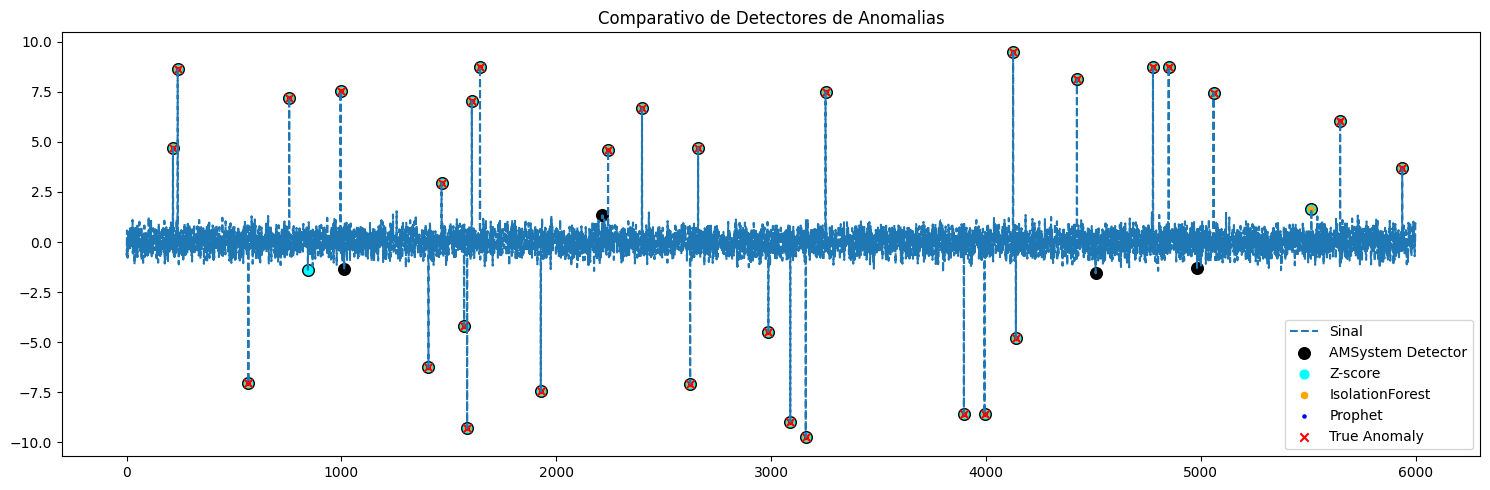

In [14]:

# === Função para gerar os dados ===
def gen_data(seed=42, n_samples=10000):
    np.random.seed(seed)
    random.seed(seed)

    t = np.linspace(0, 4 * np.pi, n_samples)
    base_signal = 0.5 * np.sin(t) + 0.3 * np.sin(3 * t) + np.random.normal(0, 0.3, n_samples)

    num_anomalies = int(0.005 * n_samples)
    anomaly_indices = sorted(random.sample(range(100, n_samples - 100), num_anomalies))
    anomaly_values = [random.choice([-1, 1]) * random.uniform(3, 10) for _ in range(num_anomalies)]

    signal = base_signal.copy()
    for idx, val in zip(anomaly_indices, anomaly_values):
        signal[idx] += val

    y_true = np.zeros(n_samples, dtype=int)
    y_true[anomaly_indices] = 1

    return signal, y_true

# === Função para avaliação ===
def evaluate(y_pred, y_true, name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name:^30} -> Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    return precision, recall, f1

# === Gerar dados e dividir ===
X, y = gen_data(seed=554, n_samples=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)

# === 1. Isolation Forest ===
iso = IsolationForest(contamination=np.mean(y_train), random_state=42)
iso.fit(X_train.reshape(-1, 1))
y_pred_iso = iso.predict(X_test.reshape(-1, 1))
y_pred_iso = (y_pred_iso == -1).astype(int)

# === 2. Prophet ===
df_train = pd.DataFrame({
    "ds": pd.date_range("2020-01-01", periods=len(X_train), freq="H"),
    "y": X_train
})
df_test = pd.DataFrame({
    "ds": pd.date_range("2020-01-01", periods=len(X_test), freq="H"),
    "y": X_test
})
model = Prophet()
model.fit(df_train)
forecast = model.predict(df_test)
residuals = df_test['y'].values - forecast['yhat'].values
threshold = 3 * np.std(residuals)
y_pred_prophet = (np.abs(residuals) > threshold).astype(int)

# === 3. Z-Score ===
window=50
series = pd.Series(X_test)
rolling_mean = series.rolling(window).mean()
rolling_std = series.rolling(window).std()
z_score = (series - rolling_mean) / rolling_std
y_pred_z = (np.abs(z_score) > 3).fillna(0).astype(int)

# === 4. AMSystemDetector (EVT custom) ===
# model_evt = AMSystem(**best_params)
# y_pred_evt = []
# for xi in X_test:
#     result = model_evt.update(xi)
#     y_pred_evt.append(result["outlier"] if result else 0)
# y_pred_evt = np.array(y_pred_evt).astype(int)

ams = AMSystemDetector()
ams.tune(X_train, y_train, n_trials=100, verbose=False)  # tuning opcional
ams.fit(X_train, y_train)
y_pred_evt = ams.predict(X_test)


# === Avaliações ===
print("\n" + "="*80)
evaluate(y_pred_iso, y_test, "Isolation Forest")
evaluate(y_pred_prophet, y_test, "Prophet Residuals")
evaluate(y_pred_z, y_test, "Z-score")
evaluate(y_pred_evt, y_test, "AMSystem Detector")
print("="*80 + "\n")

# === Plot ===
plt.figure(figsize=(15, 5))
plt.plot(X_test, "--", label='Sinal')

plt.scatter(np.where(y_pred_evt)[0], X_test[y_pred_evt == 1], c='black', label='AMSystem Detector', s=70)


plt.scatter(np.where(y_pred_z)[0], X_test[y_pred_z == 1], c='cyan', label='Z-score', s=40)
plt.scatter(np.where(y_pred_iso)[0], X_test[y_pred_iso == 1], c='orange', label='IsolationForest', s=20)
plt.scatter(np.where(y_pred_prophet)[0], X_test[y_pred_prophet == 1], c='blue', label='Prophet', s=5)
plt.scatter(np.where(y_test)[0], X_test[y_test == 1], c='red', label='True Anomaly', marker='x')

plt.legend()
plt.title("Comparativo de Detectores de Anomalias")
plt.tight_layout()
plt.show()
